In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
from pandas.api.types import CategoricalDtype
from category_encoders import MEstimateEncoder
from category_encoders import CatBoostEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import KFold, cross_val_score, StratifiedKFold
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
#Multi-Label Classification can use model which supports multilabel or model which is is used once on each y value
#Examples which support multilabel:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import RadiusNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import RidgeClassifierCV
from sklearn.multioutput import MultiOutputClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import PowerTransformer


# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s3e18/sample_submission.csv
/kaggle/input/playground-series-s3e18/train.csv
/kaggle/input/playground-series-s3e18/test.csv


/tmp/ipykernel_20/1474184820.py:39: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


In [2]:
train_df = pd.read_csv("/kaggle/input/playground-series-s3e18/train.csv")
test_df = pd.read_csv('/kaggle/input/playground-series-s3e18/test.csv')
submission = pd.read_csv("/kaggle/input/playground-series-s3e18/sample_submission.csv")
train_df.head()

,id,BertzCT,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,Chi3v,Chi4n,EState_VSA1,...,SlogP_VSA3,VSA_EState9,fr_COO,fr_COO2,EC1,EC2,EC3,EC4,EC5,EC6
0,0,323.390782,9.879918,5.875576,5.875576,4.304757,4.304757,2.754513,1.749203,0.000000,...,4.794537,35.527357,0,0,1,1,0,0,0,0
1,1,273.723798,7.259037,4.441467,5.834958,3.285046,4.485235,2.201375,1.289775,45.135471,...,13.825658,44.707310,0,0,0,1,1,0,0,0
2,2,521.643822,10.911303,8.527859,11.050864,6.665291,9.519706,5.824822,1.770579,15.645394,...,17.964475,45.660120,0,0,1,1,0,0,1,0
3,3,567.431166,12.453343,7.089119,12.833709,6.478023,10.978151,7.914542,3.067181,95.639554,...,31.961948,87.509997,0,0,1,1,0,0,0,0
4,4,112.770735,4.414719,2.866236,2.866236,1.875634,1.875634,1.036450,0.727664,17.980451,...,9.589074,33.333333,2,2,1,0,1,1,1,0


In [3]:
test_df.head()

,id,BertzCT,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,Chi3v,Chi4n,EState_VSA1,...,PEOE_VSA14,PEOE_VSA6,PEOE_VSA7,PEOE_VSA8,SMR_VSA10,SMR_VSA5,SlogP_VSA3,VSA_EState9,fr_COO,fr_COO2
0,14838,344.632371,7.283603,4.473966,5.834958,3.412257,4.651530,2.096558,1.116433,49.458581,...,13.512441,0.000000,0.000000,0.000000,26.809272,24.539800,4.794537,47.304082,1,1
1,14839,1432.410201,10.663869,7.079026,8.065215,5.297097,5.297097,3.924155,2.569694,0.000000,...,0.000000,34.947374,98.323987,9.606882,0.000000,53.378235,0.000000,43.166667,0,0
2,14840,83.352608,3.931852,1.774215,1.774215,1.073446,1.073446,0.467830,0.170838,5.969305,...,5.969305,0.000000,0.000000,6.420822,11.752550,13.344559,9.589074,24.666667,1,1
3,14841,150.255712,5.912790,3.548812,3.548812,2.595128,2.595128,1.642813,0.694113,0.000000,...,59.935299,0.000000,0.000000,0.000000,17.744066,32.290168,4.794537,26.778866,0,0
4,14842,1817.276351,24.910940,15.540529,20.047314,12.535886,17.730988,11.979618,4.431173,84.554972,...,23.468091,25.609359,0.000000,37.099000,69.141353,38.704130,50.697492,102.583333,0,0


We are just predicting "EC1 and EC2" and the other EC's don't appear in the test sample so it makes sense to drop them from the training set

# Exploratory Data Analysis

Enzymes are known to act on molecules with structural similarities with their substrates. This behaviour is called promiscuity. Scientists working in drug discovery use this behaviour to target/design drugs to either block or promote biological actions. But, correct prediction of EC class(s) of substrates associated with enzymes has been a challenge in biology. Since there is no shortage of data, ML techniques can be employed to solve the aforementioned problem.

**Points to keep in mind**
* Substrate molecules can belong to multiple EC-Classes at the same time as same molecules participate in different types of reactions in biology
* Dataset is highly imbalanced in labels
* Need an algorithm that can tackle label imbalance
* Smallest label count is 1 and highest label count is 248

There are 1039 molecules with multi-label (molecules belonging to more than one EC class). Each column in the dataset represents chemical and structural properties of these molecules.
Task here is to train an efficient classification AI.
Please note that there is huge label and class imbalance in the data.


In [4]:
train_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
id,14838.0,7418.500000,4283.505982,0.000000,3709.250000,7418.500000,11127.750000,14837.000000
BertzCT,14838.0,515.153604,542.456370,0.000000,149.103601,290.987941,652.652585,4069.959780
Chi1,14838.0,9.135189,6.819989,0.000000,4.680739,6.485270,11.170477,69.551167
Chi1n,14838.0,5.854307,4.647064,0.000000,2.844556,4.052701,7.486791,50.174588
Chi1v,14838.0,6.738497,5.866444,0.000000,2.932842,4.392859,8.527859,53.431954
Chi2n,14838.0,4.432570,3.760516,0.000000,1.949719,2.970427,5.788793,32.195368
Chi2v,14838.0,5.253221,4.925065,0.000000,2.034468,3.242775,6.609350,34.579313
Chi3v,14838.0,3.418749,3.436208,0.000000,1.160763,1.948613,4.502070,22.880836
Chi4n,14838.0,1.773472,1.865898,0.000000,0.503897,1.073261,2.534281,16.072810
EState_VSA1,14838.0,29.202823,31.728679,0.000000,5.969305,17.353601,44.876559,363.705954


In [5]:
#Check class weight for EC1 and EC2
train_shape = train_df.shape[0]
EC1_pos = train_df['EC1'].where(train_df['EC1']==1).sum()
EC2_pos = train_df['EC2'].where(train_df['EC2']==1).sum()
EC_both = train_df.loc[(train_df['EC1']==1) & (train_df['EC2']==1)]
EC_both = EC_both['EC1'].sum()

print(f'Percentage of Class EC1 = 1: {EC1_pos*100/train_shape: .2f}%')
print(f'Percentage of Class EC2 = 1: {EC2_pos*100/train_shape: .2f}%')
print(f'Percentage of both Class EC1 & EC2: {EC_both*100/train_shape: .2f}%')
print(f'Percentage of neither Class EC1 or EC2: {abs(1- EC_both*100/train_shape): .2f}%')


Percentage of Class EC1 = 1:  66.77%
Percentage of Class EC2 = 1:  79.90%
Percentage of both Class EC1 & EC2:  50.59%
Percentage of neither Class EC1 or EC2:  49.59%


In [6]:
#plt.rcParams['figure.figsize'] = [12, 8]
#train_df.hist()

Data will need to be rescaled. Need to examine each column to expose normal distributions

In [7]:
#Find outliers
train = train_df.copy()
for col in train.columns:
    mean = train[col].mean()
    lower_limit = mean - 3*train[col].std()
    upper_limit = mean + 3*train[col].std()
    outliers = train.loc[(train[col] > upper_limit) | (train[col]< lower_limit)] 
    outliers

In [8]:
#Find outliers
train = train_df[['FpDensityMorgan1','FpDensityMorgan2','FpDensityMorgan3']]
for col in train.columns:
    q25,q75 = np.percentile(train[col],[25,75])
    IQR = q75 - q25
    lower_limit = q25 - 3*IQR
    upper_limit = q75 + 3*IQR
    #Percentage of values outside of limits
    outliers = train.loc[(train[col] > upper_limit) | (train[col]< lower_limit)] 
    num_outliers = len(outliers)
    print(outliers)
    #fig, ax = plt.subplots(2)
    #sns.boxplot(train, x = col, ax = ax[0])
    #sns.boxplot(test, x = col, ax = ax[1])
    #plt.show()

       FpDensityMorgan1  FpDensityMorgan2  FpDensityMorgan3
31                  3.0               3.0               3.0
118                 3.0               3.0               3.0
213                 3.0               3.0               3.0
311                 3.0               3.0               3.0
345                 3.0               3.0               3.0
...                 ...               ...               ...
14327               3.0               3.0               3.0
14339               3.0               3.0               3.0
14680               3.0               3.0               3.0
14713               3.0               3.0               3.0
14784               3.0               3.0               3.0

[95 rows x 3 columns]
       FpDensityMorgan1  FpDensityMorgan2  FpDensityMorgan3
1452           0.312500          0.471429          1.742857
3379           0.512195          0.515625          0.842105
3422        -666.000000       -666.000000       -666.000000
4218           0.

Only real outliers between the two data sets seems to be FPMORGAN
Drop FPMORGAN extreme value from training data

Need to detect whether each feature is Normally distributed or not

Looks like a power transform is great for making the data Normally distributed

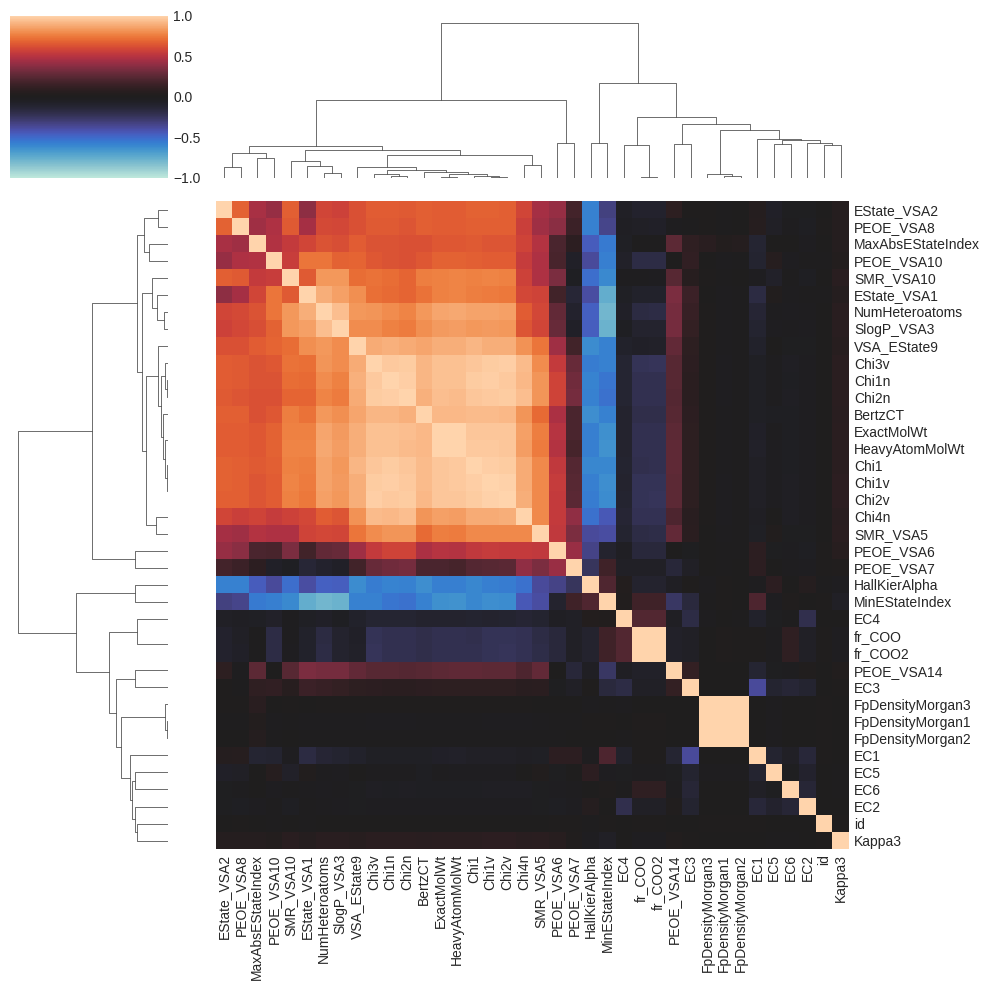

In [9]:
def corrplot(df, method="pearson", annot=True, **kwargs):
    sns.clustermap(
        df.corr(method),
        vmin=-1.0,
        vmax=1.0,
        cmap="icefire",
        method="complete",
        annot=annot,
        **kwargs,
    )

corrplot(train_df, annot=None)

Not much correlation for EC2. 
EC1 looks to have some more correlation with some features
Maybe we can use models prediction for EC1 to predict EC2

In [10]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations")
print(get_top_abs_correlations(train_df, 10))
cols_to_drop = get_top_abs_correlations(train_df, 10).reset_index()

#get only second row of columns
cols_to_drop = cols_to_drop.iloc[:,1]

Top Absolute Correlations
FpDensityMorgan1  FpDensityMorgan2    0.999216
FpDensityMorgan2  FpDensityMorgan3    0.998817
FpDensityMorgan1  FpDensityMorgan3    0.997452
fr_COO            fr_COO2             0.995697
ExactMolWt        HeavyAtomMolWt      0.994905
Chi1v             Chi2v               0.986538
Chi1n             Chi2n               0.983607
Chi2v             Chi3v               0.980093
Chi1              Chi1v               0.978411
Chi1n             Chi1v               0.977010
dtype: float64


# Creating potential features

In [11]:
#Using EC1 to predict EC2
def EC1_feature(X,y,X_test, model):
    model.fit(X,y)
    EC1_preds = pd.Series(model.predict(X_test), name = 'EC1_preds')
    return EC1_preds

In [12]:
#dropping heavily correlated features
def drop_corr(df):
    X = df.copy()
    cols_to_drop = get_top_abs_correlations(X, 10).reset_index()
    #get only second row of columns
    cols_to_drop = cols_to_drop.iloc[:,1]
    X = X.drop(cols_to_drop, axis=1)
   
    return X
#does not improve CV sscore

In [13]:
#dropping extreme outliers- FPMorgFpDensityMorgan
#t = train_df[(train_df['FpDensityMorgan1'] < 0) | (train_df['FpDensityMorgan2'] < 0) | (train_df['FpDensityMorgan3'] < 0)]
def drop_Fp_extreme(df):
    
    #Find outliers
    df = df[(df['FpDensityMorgan1'] > 0) & (df['FpDensityMorgan2'] > 0) & (df['FpDensityMorgan3'] > 0)]
    
    return df

In [14]:
#Percentage of weight of Heavy atom
def new_features(X):
    X['Weight_perc'] = X['HeavyAtomMolWt']/X['ExactMolWt']
    X['Estate_diff'] = X['MaxAbsEStateIndex']- X['MinEStateIndex']
    X['Hetero_weight'] = X['NumHeteroatoms']*X['HeavyAtomMolWt']
    X['COO_Total'] = X['fr_COO']+X['fr_COO2']
    
    return X

In [15]:
def make_mi_scores(X, y):
    X = X.copy()
    #for colname in X.select_dtypes(["object", "category"]):
    #    X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    #discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_classif(X, y,random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

In [16]:
X = train_df.copy().drop(['id','EC1','EC2', 'EC3', 'EC4','EC5','EC6'], axis = 1)
y = train_df[["EC1","EC2"]]
y_EC1 = y['EC1']
y_EC2 = y['EC2']
power = PowerTransformer()
X_scaled = pd.DataFrame(power.fit_transform(X), columns = power.get_feature_names_out())

mi_scores_EC1 = make_mi_scores(X_scaled, y_EC1)
mi_scores_EC2 = make_mi_scores(X_scaled, y_EC2)

mi_scores = pd.DataFrame({'EC1': mi_scores_EC1, 'EC2': mi_scores_EC2})
mi_scores

,EC1,EC2
BertzCT,0.029526,0.003169
Chi1,0.022549,0.003307
Chi1n,0.024032,0.008318
Chi1v,0.025261,0.002189
Chi2n,0.023763,0.007440
Chi2v,0.027142,0.004929
Chi3v,0.026383,0.003659
Chi4n,0.021973,0.006535
EState_VSA1,0.049214,0.006393
EState_VSA2,0.012967,0.000245


In [17]:
def drop_mi(mi_scores):
    EC1_labels = mi_scores[mi_scores['EC1']>0]
    EC2_labels = mi_scores[mi_scores['EC2']>0]
    return EC1_labels.index, EC2_labels.index

In [18]:
EC1_labels, EC2_labels = drop_mi(mi_scores)
EC2_labels

Index(['BertzCT', 'Chi1', 'Chi1n', 'Chi1v', 'Chi2n', 'Chi2v', 'Chi3v', 'Chi4n',
       'EState_VSA1', 'EState_VSA2', 'ExactMolWt', 'FpDensityMorgan1',
       'FpDensityMorgan2', 'FpDensityMorgan3', 'HallKierAlpha',
       'HeavyAtomMolWt', 'Kappa3', 'MaxAbsEStateIndex', 'MinEStateIndex',
       'PEOE_VSA10', 'PEOE_VSA14', 'PEOE_VSA6', 'PEOE_VSA8', 'SMR_VSA10',
       'SlogP_VSA3', 'VSA_EState9', 'fr_COO', 'fr_COO2'],
      dtype='object')

In [19]:
#Cluster Functions
def cluster_labels(df, features, n_clusters=20):
    X = df.copy()
    X_scaled = PowerTransformer().fit_transform(X)
    kmeans = KMeans(n_clusters=n_clusters, n_init=50, random_state=0)
    X_new = pd.DataFrame()
    X_new["Cluster"] = kmeans.fit_predict(X_scaled)
    return X_new


def cluster_distance(df, features, n_clusters=20):
    X = df.copy()
    kmeans = KMeans(n_clusters=20, n_init=50, random_state=0)
    X_cd = kmeans.fit_transform(X)
    # Label features and join to dataset
    X_cd = pd.DataFrame(
        X_cd, columns=[f"Centroid_{i}" for i in range(X_cd.shape[1])]
    )
    return X_cd

In [20]:
#PCA Functions
def apply_pca(X):
    # Standardize
    #if standardize:
    X_scaled = PowerTransformer().fit_transform(X)
    # Create principal components
    pca = PCA()
    X_pca = pca.fit_transform(X_scaled)
    # Convert to dataframe
    component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
    X_pca = pd.DataFrame(X_pca, columns=component_names)
    # Create loadings
    loadings = pd.DataFrame(
        pca.components_.T,  # transpose the matrix of loadings
        columns=component_names,  # so the columns are the principal components
        index=X.columns,  # and the rows are the original features
    )
    return pca, X_pca, loadings


def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=8, dpi=100)
    return axs

def pca_components(df, features):
    X = df.loc[:, features]
    _, X_pca, _ = apply_pca(X)
    return X_pca

In [21]:
pca,X_pca, loadings = apply_pca(X_scaled)

array([<Axes: title={'center': '% Explained Variance'}, xlabel='Component'>,
       <Axes: title={'center': '% Cumulative Variance'}, xlabel='Component'>],
      dtype=object)

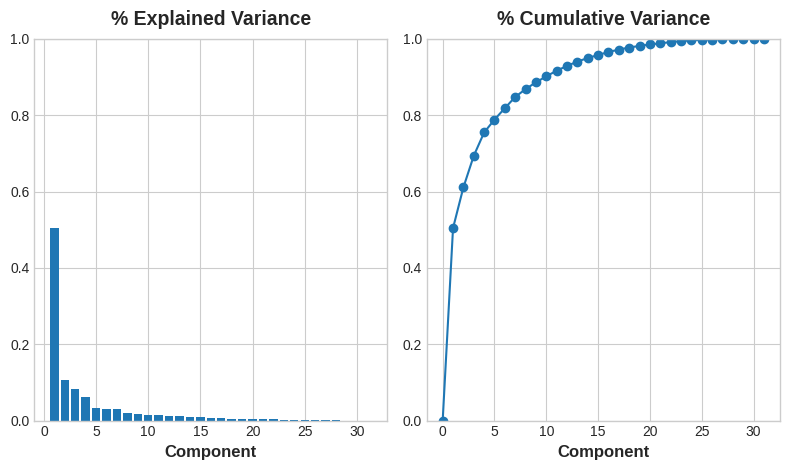

In [22]:
plot_variance(pca)

In [23]:
skf = StratifiedKFold(n_splits=5, shuffle = True, random_state = 1)

def skf_score(X,y, model, skf, both = False, y_2 = None):
    score_y = cross_val_score(
            model, X, y, cv=skf, scoring="roc_auc", error_score = 'raise'
            )
    
    if both == True: 
        score_y2 = cross_val_score(
                model, X, y_2, cv=skf, scoring="roc_auc", error_score = 'raise'
                )
        scores = pd.DataFrame({y.name: score_y, y_2.name : score_y2})
    
    else:
        scores = pd.DataFrame({y.name: score_y})
    return scores.mean(axis=1).mean()

EC1_baseline = skf_score(X, y_EC1, LGBMClassifier(random_state = 1),skf)
EC2_baseline = skf_score(X, y_EC2, LGBMClassifier(random_state = 1), skf)
print(f"EC1 Baseline score: {EC1_baseline:.5f} ROC_AUC")
print(f"EC2 Baseline score: {EC2_baseline:.5f} ROC_AUC")

EC1 Baseline score: 0.69831 ROC_AUC
EC2 Baseline score: 0.56088 ROC_AUC


EC1 performs better on the data set

In [24]:
#Check different scores for different labels:
#add models to evaluate
models = []
#models.append(('LR', LogisticRegression(max_iter = 2000, random_state = 1)))
models.append(('Ridge', RidgeClassifier(random_state = 1)))
#models.append(('RF', RandomForestClassifier(random_state = 1)))
#models.append(('KNN', KNeighborsClassifier()))
#models.append(('CART', DecisionTreeClassifier(random_state = 1)))
#models.append(('XGB', XGBClassifier(random_state = 1)))
models.append(('LGBM', LGBMClassifier(random_state = 1)))
#models.append(('SVC', SVC()))

X = train_df.copy().drop(['id','EC1','EC2', 'EC3', 'EC4','EC5','EC6'], axis = 1)

# evaluate each model in turn
results = []
names = []
print('EC1 Results')
print('*'*25)
for name, model in models:
    cv_results = skf_score(X, y_EC1, model ,skf)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
best_EC1 = {'LGBM': 0.698309  } #No Scaling, No adding new features
print(best_EC1)

print('EC2 Results')
print('*'*25)
for name, model in models:
    cv_results = skf_score(X, y_EC2, model ,skf)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
best_EC2 = {'Ridge': 0.575645} #Ridge with new features drop and scaling
print(best_EC2)

EC1 Results
*************************
Ridge: 0.672457 (0.000000)
LGBM: 0.698309 (0.000000)
{'LGBM': 0.698309}
EC2 Results
*************************
Ridge: 0.570572 (0.000000)
LGBM: 0.560880 (0.000000)
{'Ridge': 0.575645}


Without Scaling
RF works for EC1 (0.696928), LGBM (0.698309)
Ridge REgression works for EC2 (0.570572), LR (0.567607)

In [25]:
#Try with Scalers:
Scalers = [StandardScaler(), RobustScaler(), PowerTransformer()]
for scale in Scalers:
    X = train_df.copy().drop(['id','EC1','EC2', 'EC3', 'EC4','EC5','EC6'], axis = 1)
    X = scale.fit_transform(X)
    
    # evaluate each model in turn
    results = []
    names = []
    print(f'EC1 Results Scaled With {scale}')
    print('*'*25)
    for name, model in models:
        cv_results = skf_score(X, y_EC1, model ,skf)
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)
    best_EC1 = {'LGBM': 0.698309  } #No Scaling, No adding new features
    print(best_EC1)

    print(f'EC2 Results Scaled With {scale}')
    print('*'*25)
    for name, model in models:
        cv_results = skf_score(X, y_EC2, model ,skf)
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)
    best_EC2 = {'Ridge': 0.575645} #Ridge with new features drop and scaling
    print(best_EC2)

EC1 Results Scaled With StandardScaler()
*************************
Ridge: 0.672490 (0.000000)
LGBM: 0.696475 (0.000000)
{'LGBM': 0.698309}
EC2 Results Scaled With StandardScaler()
*************************
Ridge: 0.570759 (0.000000)
LGBM: 0.561704 (0.000000)
{'Ridge': 0.575645}
EC1 Results Scaled With RobustScaler()
*************************
Ridge: 0.672464 (0.000000)
LGBM: 0.696309 (0.000000)
{'LGBM': 0.698309}
EC2 Results Scaled With RobustScaler()
*************************
Ridge: 0.570582 (0.000000)
LGBM: 0.557526 (0.000000)
{'Ridge': 0.575645}
EC1 Results Scaled With PowerTransformer()
*************************
Ridge: 0.674914 (0.000000)
LGBM: 0.697312 (0.000000)
{'LGBM': 0.698309}
EC2 Results Scaled With PowerTransformer()
*************************
Ridge: 0.572488 (0.000000)
LGBM: 0.553023 (0.000000)
{'Ridge': 0.575645}


EC1 - LGBM performs best with PowerTransformer(0.697312) which is a decrease from no scaling at all
EC2 - LR and Ridge best with PowerTransformer (0.572242, 0.572488)

In [26]:
def model_eval(X, y,models):
    #evaluate each model in turn
    results = []
    names = []
    #print(f'EC1 Results Scaled With {scale}')
    #print('*'*25)
    for name, model in models:
        cv_results = skf_score(X, y['EC1'], model ,skf)
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        #print(msg)

    EC1 = pd.DataFrame(results ,names, columns = ['EC1'])

    results = []
    names = []
    #print(f'\nEC2 Results Scaled With {scale}')
    #print('*'*25)
    for name, model in models:
        cv_results = skf_score(X,y['EC2'], model ,skf)
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        #print(msg)
    EC2 = pd.DataFrame(results ,names, columns = ['EC2'])
    final = pd.concat([EC1,EC2], axis = 1)
    return(final)

In [27]:
#testing out features for models:
models = []
models.append(('LR', LogisticRegression(max_iter = 2000, random_state = 1)))
models.append(('Ridge', RidgeClassifier(random_state = 1)))
models.append(('RF', RandomForestClassifier(random_state = 1)))
models.append(('LGBM', LGBMClassifier(random_state = 1)))

#Try with Scalers:
scaler = PowerTransformer()
X= train_df.copy()
y = X[['EC1','EC2']]
y_EC1 = X['EC1']
y_EC2 = X['EC2']
X = X.drop(['id','EC1','EC2', 'EC3', 'EC4','EC5','EC6'], axis = 1)

#X= X.join(cluster_labels(X, X.columns, n_clusters=20))
#X= X.join(cluster_distance(X, X.columns, n_clusters=20))
X = X.join(pca_components(X, X.columns))

X_scaled = pd.DataFrame(scaler.fit_transform(X), columns = scaler.get_feature_names_out())
X_scaled = X_scaled.join(y_EC1)
cluster = model_eval(X_scaled, y, models)
cluster


,EC1,EC2
LR,1.0,0.625418
Ridge,1.0,0.624212
RF,1.0,0.596121
LGBM,1.0,0.612424


drop_corr improves Ridge Regression for EC2(0.573812) with scaler
adding EC1 values greatly imporves EC2 - Ridge imporves to 0.625885, LR (0.626091)
cluster distance and scaled improves both LR and Ridge for EC1 (0.697) and EC2 (0.5785)

In [28]:
def create_features(df, df_test=None):
    X = df.copy().drop(['id','EC1','EC2', 'EC3', 'EC4','EC5','EC6'], axis = 1)
    y = df[["EC1","EC2"]]
    y_EC1 = y['EC1']
    y_EC2 = y['EC2']

    power = PowerTransformer()
    
    #X = pd.DataFrame(robust.fit_transform(X), columns = robust.get_feature_names_out())
    # Combine splits if test data is given
    #
    # If we're creating features for test set predictions, we should
    # use all the data we have available. After creating our features,
    # we'll recreate the splits.
    if df_test is not None:
        X_test = df_test.copy().drop(['id'], axis = 1)
        #X_test = pd.DataFrame(power.transform(X_test), columns = robust.get_feature_names_out())
        X = pd.concat([X, X_test], ignore_index=True)

    #New Features
    #X = new_features(X)
    
    # Lesson 4 - Clustering
    #X= X.join(cluster_labels(X, X.columns, n_clusters=20))
    #X= X.join(cluster_distance(X, X.columns, n_clusters=20))

    # Lesson 5 - PCA
    #X = X.join(pca_components(X, X.columns))

    #Drop bad features
    #X = X.drop(EC2_labels, axis=1)

    

    # Reform splits
    if df_test is not None:
        X_train = X.loc[ :df.shape[0]-1, :]
        X_test = X.loc[df.shape[0]:, :]


    if df_test is not None:
        return X_train, X_test, y
    else:
        return X, y

In [29]:
def create_features_EC2(df, df_test=None, model = RidgeClassifier(), EC1_preds = None):
    X = df.copy().drop(['id','EC1','EC2', 'EC3', 'EC4','EC5','EC6'], axis = 1)
    y = df[["EC1","EC2"]]
    y_EC1 = y['EC1']
    y_EC2 = y['EC2']

    power = PowerTransformer()
        
    X = pd.DataFrame(power.fit_transform(X), columns = power.get_feature_names_out())
    X = X.join(y_EC1)
    # Combine splits if test data is given
    #
    # If we're creating features for test set predictions, we should
    # use all the data we have available. After creating our features,
    # we'll recreate the splits.
    if df_test is not None:
        X_test = df_test.copy().drop(['id'], axis = 1)
        X_test = pd.DataFrame(power.transform(X_test), columns = power.get_feature_names_out())
        X_test = X_test.join(EC1_preds)
        X = pd.concat([X, X_test], ignore_index=True)

    #Drop correlated
    X = drop_corr(X)
    
    
    # Lesson 4 - Clustering
    #X= X.join(cluster_labels(X, X.columns, n_clusters=20))
    X= X.join(cluster_distance(X, X.columns, n_clusters=20))

    # Lesson 5 - PCA
    #X = X.join(pca_components(X, X.columns))

    #Drop Bad features
    #X = X.drop(EC2_labels, axis=1)

    # Reform splits
    if df_test is not None:
        X_train = X.loc[ :df.shape[0]-1, :]
        X_test = X.loc[df.shape[0]:, :]


    if df_test is not None:
        return X_train, X_test, y
    else:
        return X, y


In [30]:
#testing out features for models:
models = []
models.append(('LR', LogisticRegression(max_iter = 2000, random_state = 1)))
models.append(('Ridge', RidgeClassifier(random_state = 1)))
models.append(('RF', RandomForestClassifier(random_state = 1)))
models.append(('LGBM', LGBMClassifier(random_state = 1)))

X, y = create_features(train_df)
baseline = model_eval(X, y, models)
baseline


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

,EC1,EC2
LR,0.668988,0.567607
Ridge,0.672457,0.570572
RF,0.696928,0.557537
LGBM,0.698309,0.560880


In [31]:
X, y = create_features_EC2(train_df)
EC2_baseline = model_eval(X, y, models)
EC2_baseline

,EC1,EC2
LR,1.0,0.625312
Ridge,1.0,0.625434
RF,1.0,0.598228
LGBM,1.0,0.602026


Baseline Score was raised for both. 
Ridge seems to work the best for both - Can we use softmax to generate prbabilities?

%%time
import optuna
from optuna.integration import LightGBMPruningCallback
X, y = create_features(train_df)


def objective(trial, X, y):
    param_grid = {
        "n_estimators": trial.suggest_int("n_estimators",50, 2000),
        #"learning_rate": trial.suggest_float("learning_rate", 1e-4, 0.3, log=True),
        #"num_leaves": trial.suggest_int("num_leaves", 10, 1000),
        "max_depth": trial.suggest_int("max_depth", 0, 10),
        "min_sample_split": trial.suggest_int("min_sample_split", 2, 10),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 5),
        #"reg_lambda": trial.suggest_float("lambda_l2", 0, 10)

    }

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

    cv_scores = np.empty(5)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model = RandomForestClassifier(random_state = 1)
        model.fit(
            X_train,
            y_train
            #eval_set=[(X_test, y_test)],
            #eval_metric="auc",
            #callbacks=[
            #    LightGBMPruningCallback(trial, "auc")
            #],  # Add a pruning callback
        )
        preds = model.predict_proba(X_test)[:, 1]
        cv_scores[idx] = roc_auc_score(y_test, preds)

    return np.mean(cv_scores)


study = optuna.create_study(direction="maximize", study_name="RF Classifier")
func = lambda trial: objective(trial, X, y_EC1)
study.optimize(func, n_trials=20)

In [32]:
#from optuna.visualization import plot_optimization_history

#plotly_config = {"staticPlot": True}

#fig = plot_optimization_history(study)
#fig.show(config=plotly_config)

In [33]:
#from optuna.visualization import plot_param_importances

#fig = plot_param_importances(study)
#fig.show(config=plotly_config)

In [34]:
#study.best_params
lgbm_params = {'n_estimators': 2634,
 'learning_rate': 0.2924911966984463,
 'num_leaves': 2270,
 'max_depth': 10,
 'min_data_in_leaf': 200,
 'lambda_l1': 15,
 'lambda_l2': 0}

#study.best_value

Take out non relevant hyperparamters

# Ridge Regression Model Tuning

%%time
import optuna
def objective(trial, X, y):
    param_grid = {
        #"penalty": trial.suggest_categorical("penalty", ['none','l1', 'l2']),
        "l1_ratio": trial.suggest_float("l1_ratio",0,1)
        #"solver": trial.suggest_categorical("solver", ['newton-cg','newton-cholesky', 'lbfgs', 'sag'])
    }

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

    cv_scores = np.empty(5)
    X, y = create_features_EC2(X)
    y = y['EC2']
    cv_scores = np.empty(5)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        model = LogisticRegression(solver = 'saga',penalty = 'elasticnet', random_state = 1, **param_grid)
        model.fit(
            X_train,
            y_train
        #    eval_set=[(X_test, y_test)],
        #    eval_metric="auc"
        )
        #decision = model.decision_function(X_test)
        #preds = np.exp(decision) / np.sum(np.exp(decision))
        preds = model.predict_proba(X_test)[:,1]
        cv_scores[idx] = roc_auc_score(y_test, preds)

    return np.mean(cv_scores)


study = optuna.create_study(direction="maximize", study_name="Logistic Regression")
func = lambda trial: objective(trial, train_df, y)
study.optimize(func, n_trials=20)

In [35]:
#log_params = study.best_params
log_params = {'solver': 'saga', 'penalty': 'l1', 'C': 0.13257522312915415}
#study.best_value

In [36]:
#from optuna.visualization import plot_optimization_history

#plotly_config = {"staticPlot": True}

#fig = plot_optimization_history(study)
#fig.show(config=plotly_config)

In [37]:
#ridge_params = study.best_params
ridge_params = {'alpha': 1.0, 'solver': 'auto'}
#0.6257528560035565

In [38]:
submission.head()

,id,EC1,EC2
0,14838,0.5,0.5
1,14839,0.5,0.5
2,14840,0.5,0.5
3,14841,0.5,0.5
4,14842,0.5,0.5


In [39]:
from sklearn.ensemble import VotingClassifier
EC1_voter = VotingClassifier([('rf',RandomForestClassifier(random_state = 1)),('lgbm',LGBMClassifier(random_state = 1))], voting = 'soft')

In [40]:
def final_model_test(df_train, df_test, model_1,model_2):
    #predictions for EC1
    X_train, X_test, y = create_features(df_train, df_test)
    model_1.fit(X_train, y['EC1'])
    
    hard_pred_EC1 = pd.Series(model_1.predict(X_test), name = 'EC1')
    predictions_EC1 = model_1.predict_proba(X_test)
    EC1_prob = pd.DataFrame(predictions_EC1[:,1], columns = ['EC1'])
    print('Finished EC1 Predictions')
    
    #predictions for EC2
    X_train, X_test, y = create_features_EC2(df_train, df_test, model, hard_pred_EC1)
    model_2.fit(X_train, y['EC2'])
    #decision = model_2.decision_function(X_test)
    #predictions_EC2 = np.exp(decision) / np.sum(np.exp(decision))
    predictions_EC2 = model_2.predict_proba(X_test)
    EC2_prob = pd.DataFrame(predictions_EC2[:,1], columns = ['EC2'])
    print('Finished EC2 Predictions')

    output = pd.concat([test_df['id'], EC1_prob, EC2_prob], axis=1)
    
    output.to_csv('my_submission.csv', index=False)
    print("Your submission was successfully saved!")
    
    return output

rf = RandomForestClassifier(random_state = 1)
lgbm = LGBMClassifier(random_state = 1)
#ridge = RidgeClassifier(**ridge_params, random_state = 1)
log = LogisticRegression(**log_params, max_iter = 2000, random_state = 1)
output = final_model_test(train_df, test_df, EC1_voter, log)
output.head()

Finished EC1 Predictions
Finished EC2 Predictions
Your submission was successfully saved!


,id,EC1,EC2
0,14838,0.430267,0.851072
1,14839,0.831278,0.820756
2,14840,0.745588,0.732328
3,14841,0.779965,0.793126
4,14842,0.795124,0.727760


What does fr_COO represent? What is the scale of 0-8? Should it be treated as categorical data instead of integer?

No clear correlations to EC1 and EC2 but many features seem to be strongly correlated with eachother.

Much of the data has outliers. Worst features are Kappa3 and FPDensityMorgan.